In [1]:
from base import *
from ann import *
from sklearn.model_selection import train_test_split

1. Capacidad de modelado: Entrene redes neuronales para resolver el problema de clasificación de las espirales anidadas que creamos en el TP 0. Use un número creciente de neuronas en la capa intermedia: 2, 10, 20, 40. Valores posibles para los demás parámetros de entrenamiento: learning rate 0.1, momentum 0.9, 600 datos para ajustar los modelos (20% de ese conjunto separarlo al azar para conjunto de validación), 2000 para testear, 1000 evaluaciones del entrenamiento, cada una de 20 épocas. Para cada uno de los cuatro modelos obtenidos, graficar en el plano xy las clasificaciones sobre el conjunto de test. Comentar.

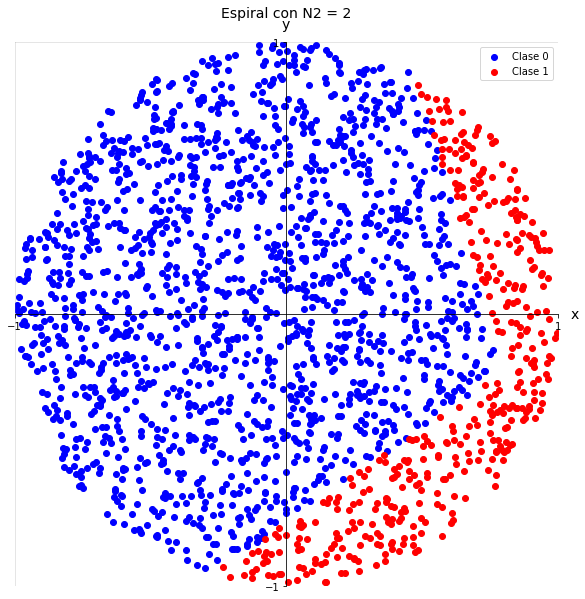

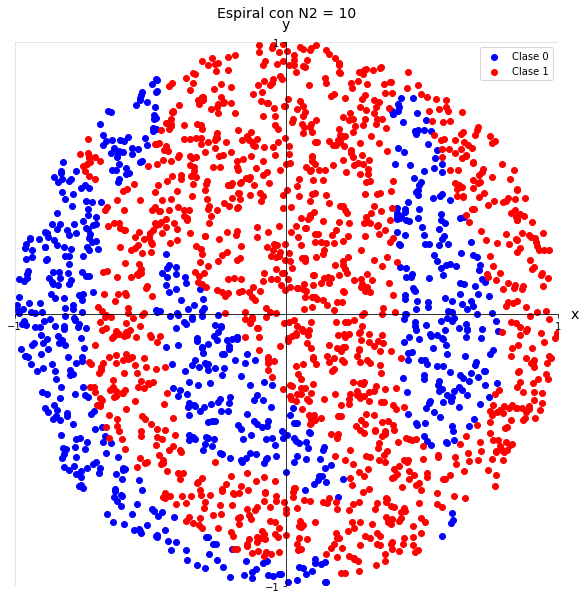

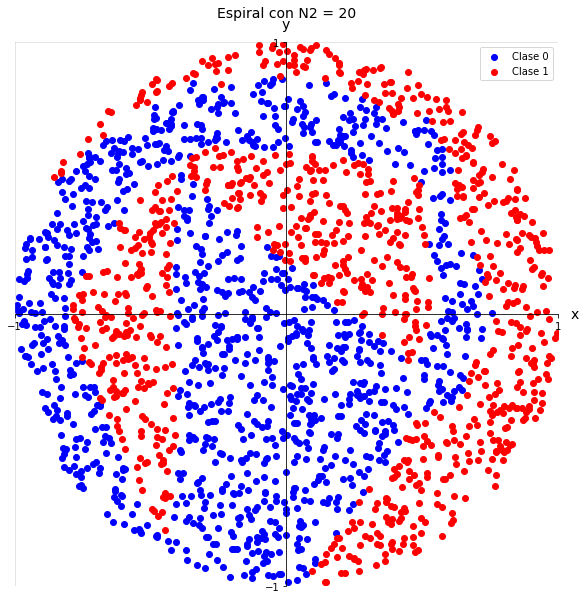

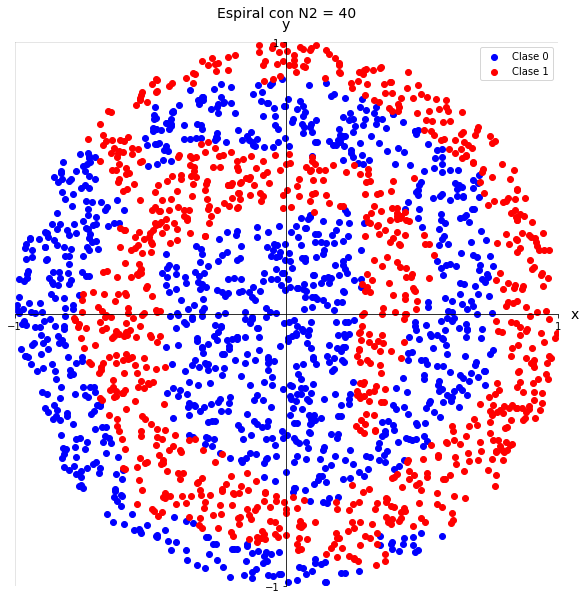

In [2]:
def ejercicio_uno():
  N2_values = [2, 10, 20, 40]
  learning_rate = 0.1
  momentum = 0.9
  epocas = 20
  evaluaciones = 1000

  df_train_val = GeneradorDFEspiral(600, 1).generar_puntos_curva()
  X_train_val, y_train_val = df_train_val[[0, 1]], df_train_val['Clase']
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

  df_test = GeneradorDFEspiral(2000, 1).generar_puntos_curva()
  X_test, y_test = df_test[[0,1]], df_test['Clase']

  for N2 in N2_values:
    mlp = MLP(epocas, learning_rate, momentum, N2)
    best_red, _, _, _ = entrenar_red(mlp.clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)

    predict_test = best_red.predict(X_test)
    df_predict = df_test.copy(deep=True)
    df_predict['Clase'] = predict_test

    GraficadorDF(df_predict).graph_puntos(titulo="Espiral con N2 = " + str(N2))

ejercicio_uno()

Los resultados obtenidos para este problema son notablemente peores que los dados a partir de los árboles de decisión, siendo el espiral con N2=40 el que más intenta asemejarse a uno.

---

2. Mínimos locales: 
 - Baje el dataset dos-elipses de la descargas. 
 - Realice varios entrenamientos con los siguientes parámetros: 6 neuronas en la capa intermedia, 500 patrones en el training set, de los cuales 400 se usan para entrenar y 100 para validar el modelo (sacados del .data), 2000 patrones en el test set (del .test), 300 evaluaciones del entrenamiento, cada una de 50 épocas. 
 - Pruebe distintos valores de momentum y learning-rate (valores usuales son 0, 0.5, 0.9 para el momentum y 0.1, 0.01, 0.001 para el learning-rate, pero no hay por qué limitarse a esos valores, para tratar de encontrar el mejor mínimo posible de la función error. El valor que vamos a usar es el promedio de 10 entrenamientos iguales, dado que los entrenamientos incorporan el azar. Como guía, con los parámetros dados, hay soluciones entre 5% y 6% de error en test, y tal vez mejores. 
 - Confeccione una tabla con los valores usados para los parámetros y el resultado en test obtenido (la media de las 10 ejecuciones). 
 - Haga una gráfica de mse de train, validación y test en función del número de épocas para los valores seleccionados (los mejores valores de eta y alfa). 



In [16]:
from math import inf

def dfs():
  dos_e_dfs = GeneradorDFCSV(name="dos_elipses")

  # Se toma una muestra aleatoria de la mitad de df_data ya que el dataset cuenta con 1000 filas. 
  df_train_val = dos_e_dfs.df_data.sample(frac=0.5)
  X_train_val, y_train_val = df_train_val[[0, 1]], df_train_val['Clase']
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

  df_test = dos_e_dfs.df_test
  X_test, y_test = df_test[[0, 1]], df_test['Clase']

  return X_train, X_val, y_train, y_val, X_test, y_test

def ejercicio_dos():
  X_train, X_val, y_train, y_val, X_test, y_test = dfs()
  N2 = 6
  evaluaciones = 300
  epocas = 50

  eta_values = [0.1, 0.01, 0.001]   # learning rate
  alfa_values = [0, 0.5, 0.9]       # momentum

  tabla = []
  best_mean_test_error = inf

  for (eta, alfa) in [(e,a) for e in eta_values for a in alfa_values]:
    for i in range(10):
      error_train = []
      error_val = []
      error_test = []

      mlp = MLP(epocas, eta, alfa, N2)
      _, error_train_data, error_val_data, error_test_data = entrenar_red(mlp.clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)

      error_train.append(error_train_data)
      error_val.append(error_val_data)
      error_test.append(error_test_data)

    error_train = np.asarray(error_train)
    error_val = np.asarray(error_val)
    error_test = np.asarray(error_test)

    mean_train_error = error_train.mean(axis=0)
    mean_val_error = error_val.mean(axis=0)
    mean_test_error = error_test.mean(axis=0)

    min_val_error = np.min(mean_val_error)
    index_min_val_error = np.where(mean_val_error == min_val_error)[0][0]

    min_mean_test_error = mean_test_error[index_min_val_error]

    if min_mean_test_error < best_mean_test_error:
      best_mean_test_error = min_mean_test_error
      best_eta = eta
      best_alfa = alfa
      best_train_error = np.copy(mean_train_error)
      best_val_error = np.copy(mean_val_error)
      best_test_error = np.copy(mean_test_error)

    #print(mean_train_error)
    tabla.append([eta, alfa, min_mean_test_error])

  errores = []
  for i in range(evaluaciones):
    errores.append([best_train_error[i], i * epocas, "Error train"])
    errores.append([best_val_error[i], i * epocas, "Error validación"])
    errores.append([best_test_error[i], i * epocas, "Error test"])

  df_errores = pd.DataFrame(errores, columns=["Error", "Épocas", "Clase"])
  df_tabla = pd.DataFrame(tabla, columns=["eta", "alfa", "Media error test"])

  return df_errores, df_tabla, best_eta, best_alfa, best_mean_test_error


In [ ]:
df_errores, df_tabla, best_eta, best_alfa, best_mean_test_error = ejercicio_dos()


In [25]:
print(f"Mejor learning rate: {best_eta}; mejor momentum: {best_alfa}; mejor promedio de error en test: {best_mean_test_error}")
df_tabla

Mejor learning rate: 0.1; mejor momentum: 0.9; mejor promedio de error en test: 0.08550000000000002


,eta,alfa,Media error test
0,0.100,0.0,0.1530
1,0.100,0.5,0.1575
2,0.100,0.9,0.0855
3,0.010,0.0,0.2435
4,0.010,0.5,0.2435
5,0.010,0.9,0.1530
6,0.001,0.0,0.2435
7,0.001,0.5,0.2435
8,0.001,0.9,0.2435


In [22]:
#df_errores.to_csv("./datasets/ej2/df_errores.csv")
#df_tabla.to_csv("./datasets/ej2/df_tabla.csv")

def graph_errores(error_df: pd.DataFrame, referencia):
  fig, ax = plt.subplots(figsize=(15, 10))
  clases = pd.unique(error_df['Clase'])

  for c in clases:
    df = error_df[error_df['Clase'] == c]
    df = df.groupby(referencia).mean().reset_index()

    switch={
      "Error train": ":",
      "Error validación": "-.",
      "Error test": "-"

    }
    
    plt.plot(df[referencia], df['Error'], linestyle=switch.get(c, ":"))

  ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

  plt.legend(clases, ncol = 4)
  plt.xlabel(referencia, size=14, labelpad=20)
  plt.ylabel('Error', size=14, labelpad=20)


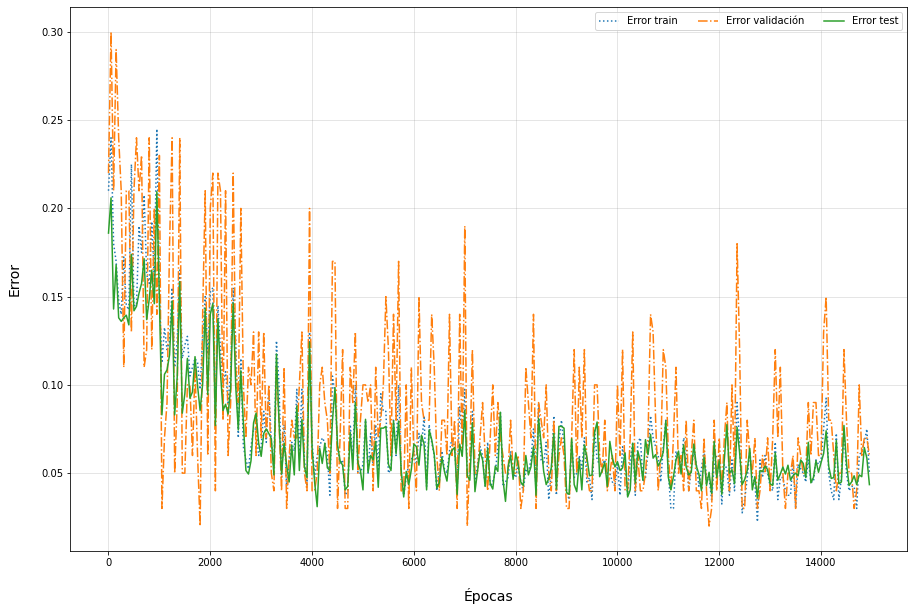

In [23]:
graph_errores(df_errores, referencia='Épocas')

Luego de entrenar todas las redes con todas las combinaciones de learning rate y momentum posibles, se obtuvo que el mejor learning rate fue de 0.1 y el mejor momentum de 0.9, cuyo promedio de error de tests fue 0.0855 (el menor de todos los calculados). También se pudo verificar que los valores de error de test oscilan entre 0.05 (5%) y 0.06 (6%) como se especificaba en la consigna.

Los valores de error de test y entrenamiento parecen mantenerse cercanos, por lo cual podríamos afirmar que no se produce sobreajuste. 

---